In [1]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA,SparsePCA
import matplotlib.pyplot as plt
import os
import glob
from collections import defaultdict
from ephysvibe.trials import align_trials, select_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
from ephysvibe.task import task_constants
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from scipy import stats
seed=2024

In [2]:
def to_python_hdf5(dat:List, save_path: Path):
    """Save data in hdf5 format."""
    # save the data
    with h5py.File(save_path, "w") as f:
        for i_d in range(len(dat)):
            group = f.create_group(str(i_d))

            for key, value in zip(dat[i_d].keys(), dat[i_d].values()):
                group.create_dataset(key, np.array(value).shape, data=value)
    f.close()

In [3]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

## Read data

In [4]:
if platform.system() == "Linux":
    basepath = (
        "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/linear_reg/pfc_from_v4"
    )
elif platform.system() == "Windows":
    basepath = 'C:/Users/camil/Documents/int/result/v4_from_pfc/'#"C:/Users/camil/Documents/int/"

In [5]:
neu_path = basepath + "*.h5"
path_list = np.array(glob.glob(neu_path))
all_sess = []
for path in path_list:
    all_sess.append(from_python_hdf5(load_path=path)[0])
    

In [25]:
max_acc: Dict[str, Dict[str, list]] = defaultdict(lambda: defaultdict(list))

for i_samp in ['11','15','51','55','0']:
    for i_s in range(len(all_sess)):
        if all_sess[i_s][i_samp].shape[-1]>8:
            imax_acc = np.mean(all_sess[i_s][i_samp][:,:,-2],axis=0)
            max_acc[i_samp]['in']+=[imax_acc[0]]
            max_acc[i_samp]['in_sem']+=[stats.sem(all_sess[i_s][i_samp][:,0,-1])]
            max_acc[i_samp]['out']+=[imax_acc[1]]
            max_acc[i_samp]['out_sem']+=[stats.sem(all_sess[i_s][i_samp][:,1,-1])]

[Text(0.5, 0, 'Attend IN'), Text(0, 0.5, 'Attend Out')]

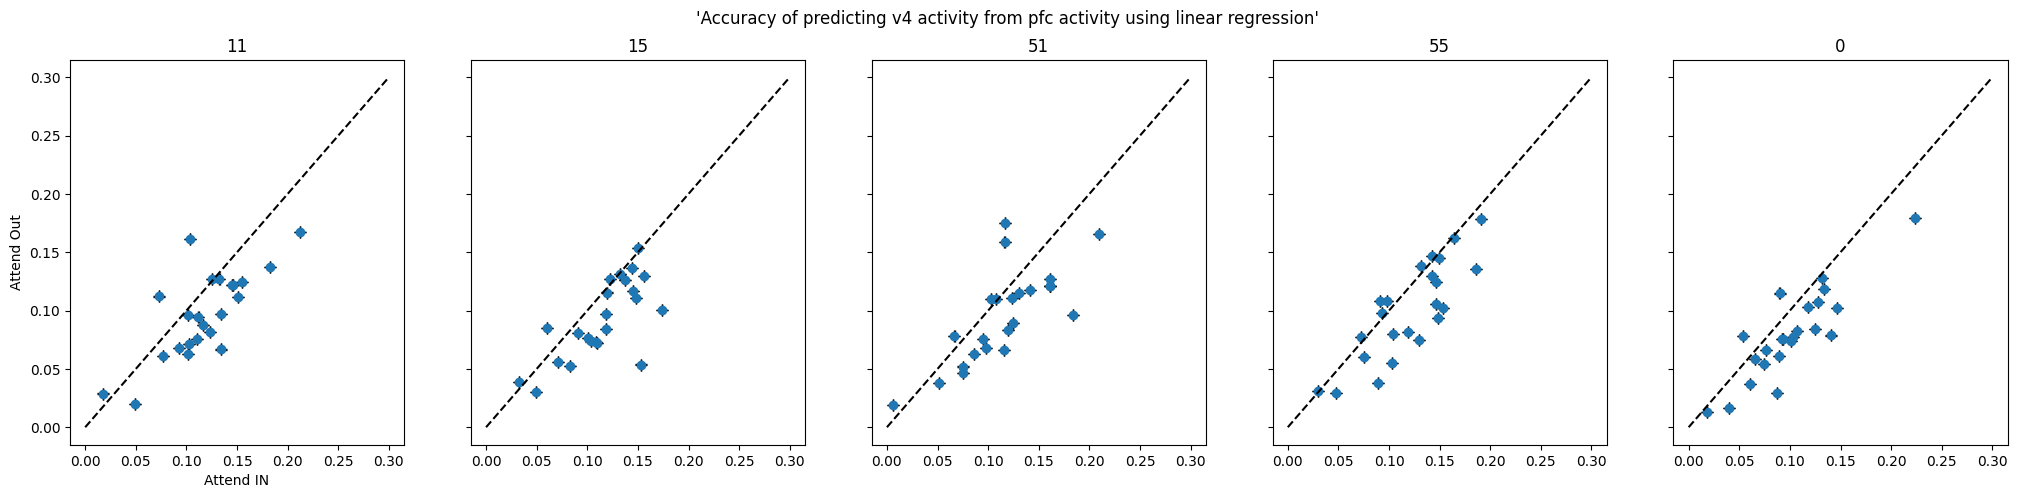

In [26]:
f,ax=plt.subplots(1,5,figsize=(25,5),sharey=True,sharex=True)
allxerr,allyerr=[],[]
for iax,i_samp in enumerate(['11','15','51','55','0']):
    _=ax[iax].scatter(max_acc[i_samp]['in'],max_acc[i_samp]['out'])
    ax[iax].plot([0,0.3],[0,0.3],'k--')
    ax[iax].set(title=i_samp)
    yerr=abs(np.array(stats.norm.interval(0.1, loc=max_acc[i_samp]['out'], scale=max_acc[i_samp]['out_sem']))-max_acc[i_samp]['out'])
    xerr= abs(np.array(stats.norm.interval(0.1, loc=max_acc[i_samp]['in'], scale=max_acc[i_samp]['in_sem']))-max_acc[i_samp]['in'])
    allxerr.append(xerr)
    allyerr.append(yerr)
    ax[iax].errorbar(max_acc[i_samp]['in'],max_acc[i_samp]['out'],yerr=yerr, xerr=xerr,
        fmt='none',     # don't connect data points
        ecolor='black', # color of error lines
        elinewidth=1,   # width of error lines
        capsize=4,      # length of error caps
        zorder=-1,      # put error bars behind scatter points
    )
f.suptitle(str(all_sess[0]['comment'])[1:])
ax[0].set(xlabel='Attend IN',ylabel='Attend Out')

[Text(0.5, 0, 'Attend IN'), Text(0, 0.5, 'Attend Out')]

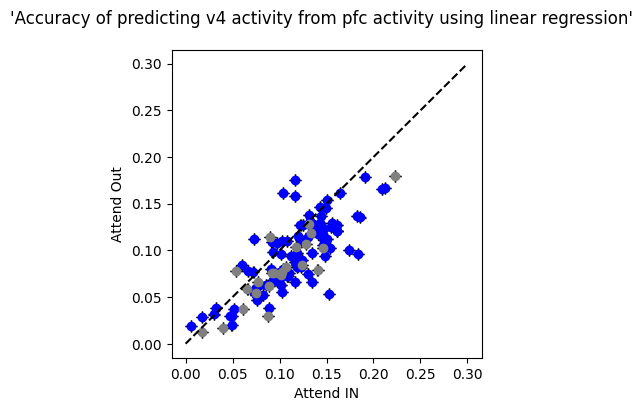

In [27]:
f,ax=plt.subplots(figsize=(4,4),sharey=True,sharex=True)
allxerr,allyerr=[],[]
for iax,i_samp in enumerate(['11','15','51','55','0']):
    color='b'
    if i_samp == '0':
        color='grey'
    _=ax.scatter(max_acc[i_samp]['in'],max_acc[i_samp]['out'],color=color)
    yerr=abs(np.array(stats.norm.interval(0.1, loc=max_acc[i_samp]['out'], scale=max_acc[i_samp]['out_sem']))-max_acc[i_samp]['out'])
    xerr= abs(np.array(stats.norm.interval(0.1, loc=max_acc[i_samp]['in'], scale=max_acc[i_samp]['in_sem']))-max_acc[i_samp]['in'])
    allxerr.append(xerr)
    allyerr.append(yerr)
    ax.errorbar(max_acc[i_samp]['in'],max_acc[i_samp]['out'],yerr=yerr, xerr=xerr,
        fmt='none',     # don't connect data points
        ecolor='black', # color of error lines
        elinewidth=1,   # width of error lines
        capsize=4,      # length of error caps
        zorder=-1,      # put error bars behind scatter points
    )
ax.plot([0,0.3],[0,0.3],'k--')
f.suptitle(str(all_sess[0]['comment'])[1:])
ax.set(xlabel='Attend IN',ylabel='Attend Out')

[Text(0.5, 0, 'Attend IN'), Text(0, 0.5, 'Attend Out')]

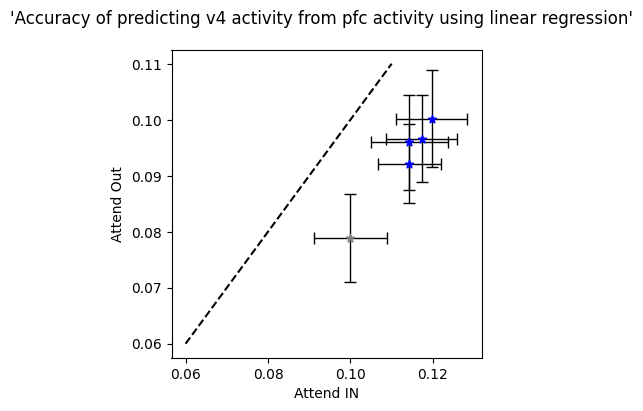

In [37]:
f,ax=plt.subplots(figsize=(4,4),sharey=True,sharex=True)
allxerr,allyerr=[],[]
for iax,i_samp in enumerate(['11','15','51','55','0']):
    color='b'
    if i_samp == '0':
        color='grey'
    x=np.array(max_acc[i_samp]['in'])
    y=np.array(max_acc[i_samp]['out'])
    yerr=stats.sem(y)
    xerr= stats.sem(x)
    meanx=np.mean(x)
    meany=np.mean(y)
    ax.errorbar(meanx,meany,yerr=yerr, xerr=xerr,
        fmt='none',     # don't connect data points
        ecolor='black', # color of error lines
        elinewidth=1,   # width of error lines
        capsize=4,      # length of error caps
        zorder=-1,      # put error bars behind scatter points
    )
    #_=ax.scatter(x,y,color=color)

    _=ax.scatter(meanx,meany,marker='*',color=color)
ax.plot([0.06,0.11],[0.06,0.11],'k--')
f.suptitle(str(all_sess[0]['comment'])[1:])
ax.set(xlabel='Attend IN',ylabel='Attend Out')

In [9]:
mean_frx ={'51':{},'11':{},'55':{},'15':{},'0':{}}
mean_fry ={'51':{},'11':{},'55':{},'15':{},'0':{}}
for i_samp in ['51','11','55','15','0']:
    for i_cond in ['in','out']:
        xkey = area_x+ '_'+i_samp + '_' + i_cond
        meanx=np.mean(acc[xkey],axis=-1)*1000
        ykey = area_y+ '_'+i_samp + '_' + i_cond
        meany=np.mean(acc[ykey],axis=-1)*1000
        mean_frx[i_samp][i_cond]=meanx
        mean_fry[i_samp][i_cond]=meany

NameError: name 'area_x' is not defined

In [ ]:
f,ax=plt.subplots(1,5,figsize=(25,5),sharey=True,sharex=True)
allxerr,allyerr=[],[]
for iax,i_samp in enumerate(['11','15','51','55','0']):
    # area x
    meanfr = np.mean(mean_frx[i_samp]['in'])
    stdfr= stats.sem(mean_frx[i_samp]['in'],axis=None)
    _=ax[iax].scatter(1,meanfr,label=['in'] ,color='r')
    ax[iax].errorbar(x=1,y=meanfr,yerr=stdfr,fmt='none', ecolor='black', elinewidth=1,capsize=4,zorder=-1)
    meanfr = np.mean(mean_frx[i_samp]['out'])
    stdfr= stats.sem(mean_frx[i_samp]['out'],axis=None)
    _=ax[iax].scatter(2,meanfr,label=['out'],color='r' )
    ax[iax].errorbar(x=2,y=meanfr,yerr=stdfr,fmt='none', ecolor='black', elinewidth=1,capsize=4,zorder=-1)
    # area y
    meanfr = np.mean(mean_fry[i_samp]['in'])
    stdfr= stats.sem(mean_fry[i_samp]['in'],axis=None)
    _=ax[iax].scatter(1,meanfr,label=['in'] ,color='b')
    ax[iax].errorbar(x=1,y=meanfr,yerr=stdfr,fmt='none', ecolor='black', elinewidth=1,capsize=4,zorder=-1)
    meanfr = np.mean(mean_fry[i_samp]['out'])
    stdfr= stats.sem(mean_fry[i_samp]['out'],axis=None)
    _=ax[iax].scatter(2,meanfr,label=['out'],color='b' )
    ax[iax].errorbar(x=2,y=meanfr,yerr=stdfr,fmt='none', ecolor='black', elinewidth=1,capsize=4,zorder=-1)
            

IndentationError: expected an indented block (3394953621.py, line 4)

In [ ]:
all_sess[i_s].keys()

dict_keys(['0', '11', '15', '51', '55', 'comment', 'computation_date', 'session', 'step', 't_end', 't_st', 'time_before', 'win'])